In [1]:
import tensorflow as tf
import warnings
from tensorflow.keras import models,layers
from keras.models import Sequential
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 512
BATCH_SIZE = 32
CHANNELS = 2
EPOCHS = 5

In [5]:
df = tf.keras.preprocessing.image_dataset_from_directory(
    "Radiography",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
    )

Found 4201 files belonging to 2 classes.


In [7]:
class_names = df.class_names
class_names

['Normal', 'Tuberculosis']

In [9]:
len(df)

132

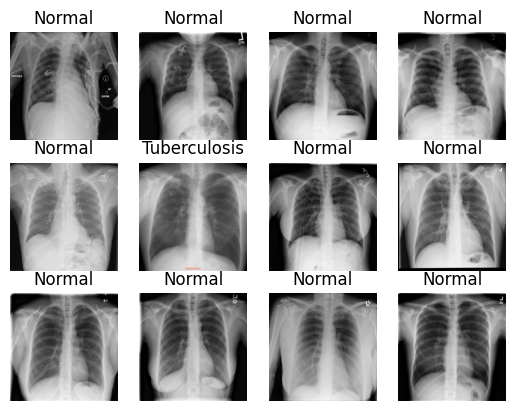

In [11]:
for image_batch, label_batch in df.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [12]:
len(df)

132

In [ ]:
80% ==> training
20% ==> 10% validation, 10% test

In [17]:
train_size = 0.8
len(df)*train_size

105.60000000000001

In [19]:
train_ds = df.take(105)
len(train_ds)

105

In [21]:
test_ds = df.skip(105)
len(test_ds)

27

In [23]:
val_size = 0.1
len(df)*val_size

13.200000000000001

In [25]:
val_ds = test_ds.take(13)
len(val_ds)

13

In [27]:
test_ds = test_ds.skip(13)
len(test_ds)

14

In [29]:
def get_dataset_partitions_tf(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split*ds_size)

    train_ds = ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    ds.skip(train_size)
    
    return train_ds, val_ds, test_ds

In [31]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(df)

In [33]:
len(train_ds)

105

In [35]:
len(val_ds)

13

In [37]:
len(test_ds)

14

In [39]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [41]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [43]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [ ]:
# Updated input shape to match the processed grayscale data
input_shape = (512, 512, 2)  # Expecting 2 channels directly
n_classes = 2

# Sequential model
model = models.Sequential([
    # Input layer with 2 channels
    layers.InputLayer(input_shape=input_shape),

    # Convolutional layers
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Flatten and Dense layers
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

# Build the model
model.build(input_shape=(None, 512, 512, 2))

# Print the model summary
model.summary()

def convert_to_two_channels(image, label):
    image = tf.image.rgb_to_grayscale(image)  # Convert RGB to grayscale
    image = tf.concat([image, image], axis=-1)  # Duplicate grayscale channel to make 2 channels
    return image, label


In [47]:
train_ds = train_ds.map(convert_to_two_channels)
val_ds = val_ds.map(convert_to_two_channels)

In [49]:
for image, label in train_ds.take(1):
    print(image.shape, label)


(32, 512, 512, 2) tf.Tensor([0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 1 0 0 0 1 0 0 1 0 0 1 0 0], shape=(32,), dtype=int32)


In [51]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [53]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/5
105/105 ━━━━━━━━━━━━━━━━━━━━ 494s 5s/step - accuracy: 0.8391 - loss: 221.9670 - val_accuracy: 0.9471 - val_loss: 0.1729
Epoch 2/5
105/105 ━━━━━━━━━━━━━━━━━━━━ 493s 5s/step - accuracy: 0.9413 - loss: 0.1774 - val_accuracy: 0.9543 - val_loss: 0.1228
Epoch 3/5
105/105 ━━━━━━━━━━━━━━━━━━━━ 461s 4s/step - accuracy: 0.9721 - loss: 0.0816 - val_accuracy: 0.9591 - val_loss: 0.2483
Epoch 4/5
105/105 ━━━━━━━━━━━━━━━━━━━━ 504s 5s/step - accuracy: 0.9708 - loss: 0.1145 - val_accuracy: 0.9615 - val_loss: 0.1773
Epoch 5/5
105/105 ━━━━━━━━━━━━━━━━━━━━ 496s 5s/step - accuracy: 0.9791 - loss: 0.1181 - val_accuracy: 0.9808 - val_loss: 0.0656


In [57]:
def convert_to_two_channels(image, label):
    image = tf.image.rgb_to_grayscale(image)  # Convert RGB to grayscale (1 channel)
    image = tf.concat([image, image], axis=-1)  # Duplicate grayscale channel (now 2 channels)
    return image, label


In [59]:
train_ds = train_ds.map(lambda x, y: convert_to_two_channels(x, y))
val_ds = val_ds.map(lambda x, y: convert_to_two_channels(x, y))
test_ds = test_ds.map(lambda x, y: convert_to_two_channels(x, y))


In [61]:
scores = model.evaluate(test_ds)

14/14 ━━━━━━━━━━━━━━━━━━━━ 13s 788ms/step - accuracy: 0.9748 - loss: 0.0920


In [63]:
scores


[0.09576629102230072, 0.96875]

In [65]:
history

In [67]:
history.params

{'verbose': 1, 'epochs': 5, 'steps': 105}

In [69]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [71]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

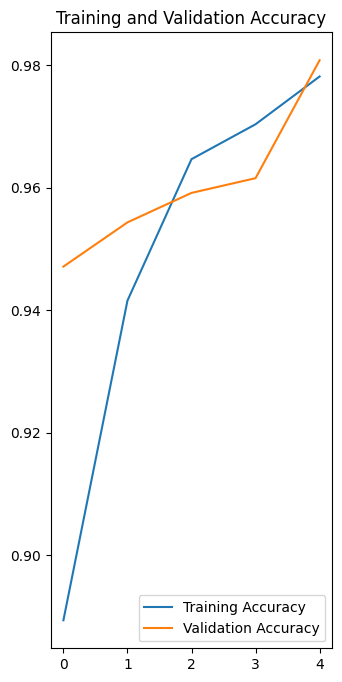

In [73]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label = 'Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')



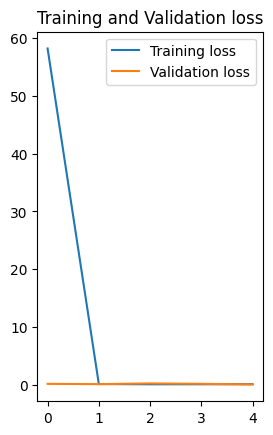

In [75]:
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), loss, label = 'Training loss')
plt.plot(range(EPOCHS), val_loss, label = 'Validation loss')
plt.legend(loc='upper right')
plt.title('Training and Validation loss')
plt.show()

First image to predict
Actual label: Tuberculosis
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 881ms/step
Predicted label: Tuberculosis


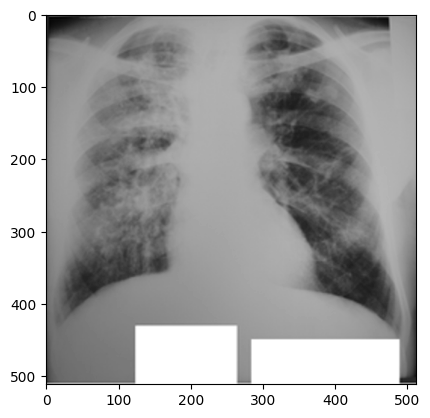

In [79]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("First image to predict")
    plt.imshow(first_image[..., 0], cmap="gray")  # Select one channel and use grayscale
    print("Actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("Predicted label:",class_names[np.argmax(batch_prediction[0])])

In [81]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


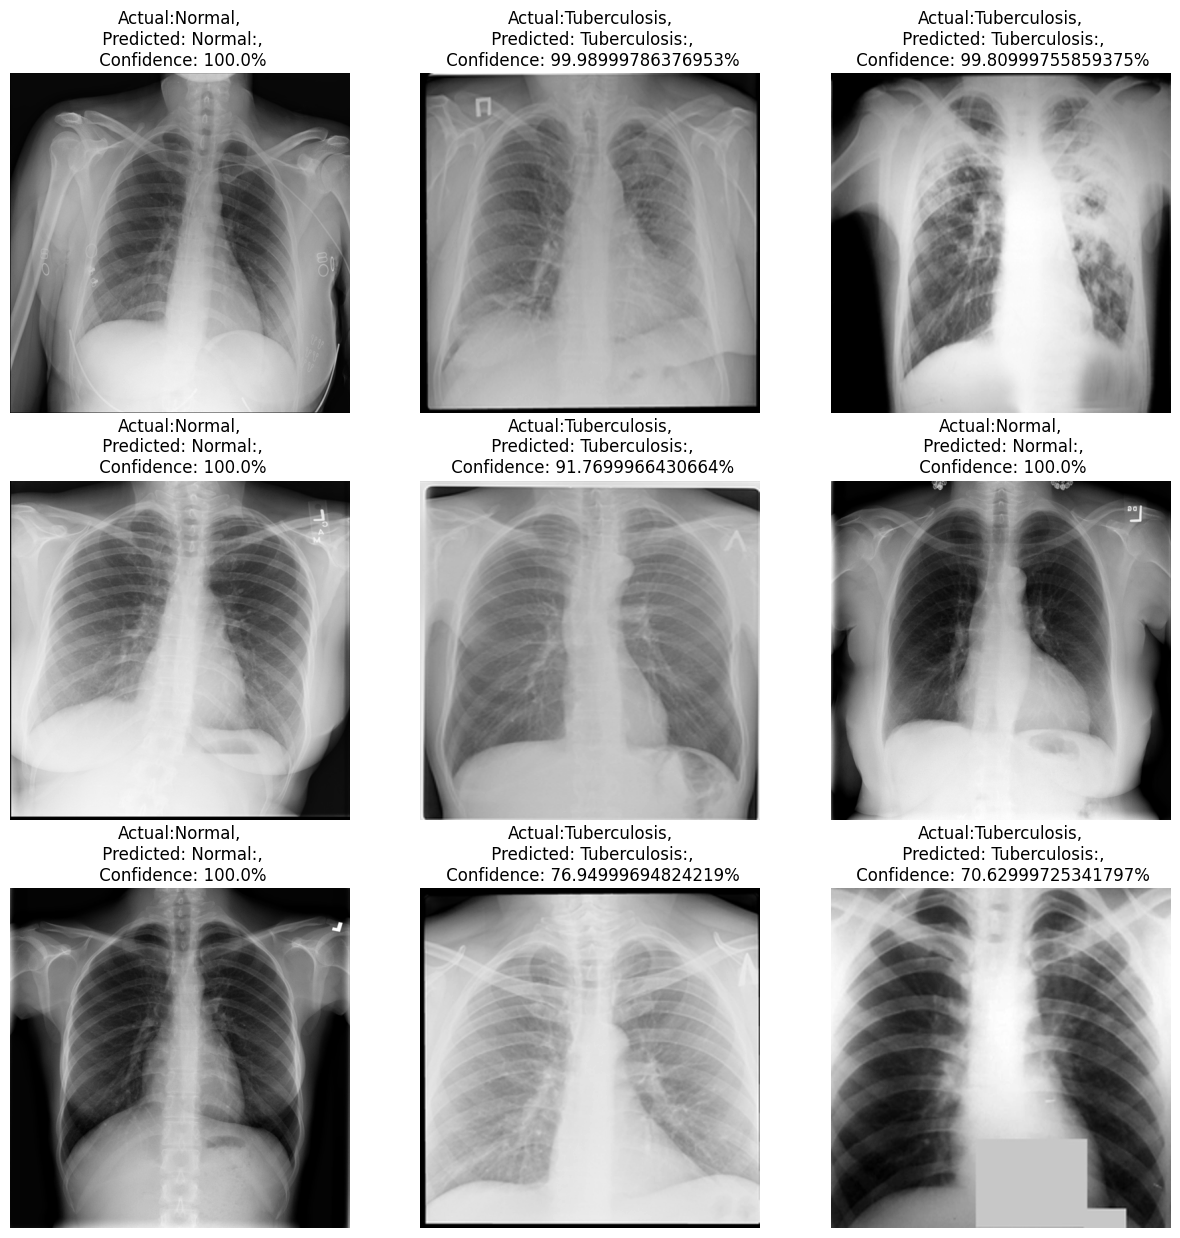

In [87]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy()[..., 0], cmap="gray")


        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual:{actual_class},\n Predicted: {predicted_class}:,\n Confidence: {confidence}%")
        plt.axis("off")

In [91]:
model_version = 2
model.save("../models/2.h5")